Credit [DNN tutorial](https://becominghuman.ai/build-your-own-neural-network-for-cifar-10-using-pytorch-9bdffb389b7a)

In [ ]:
import numpy as np
import cv2
import csv
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt


from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Load preprocessed data for DNN
file_path = '/content/drive/MyDrive/CV Project Workspace/Project_Code/unimodal_data/'
fetched_data = np.zeros([11307, 68*68])

with open(file_path + 'total_data_with_label' + ".csv", 'r') as file:
  csvreader = csv.reader(file)
  example = 0
  for row in csvreader:
    fetched_data[example] = row
    example+=1

FileNotFoundError: ignored

In [ ]:
import random

example_nums = fetched_data.shape[0]
train_example_nums = int(0.8 * example_nums)
test_example_nums = int(0.1 * example_nums)
validation_example_nums = example_nums - train_example_nums - test_example_nums

random_ids = [i for i in range(example_nums)]
random.Random(4).shuffle(random_ids)

random_train_ids = random_ids[:train_example_nums]
random_test_ids = random_ids[train_example_nums:train_example_nums+test_example_nums]
random_validation_ids = random_ids[train_example_nums+test_example_nums:]

print(len(random_train_ids), len(random_test_ids), len(random_validation_ids))


X_train = torch.as_tensor(fetched_data[random_train_ids][:,1:])
Y_train = torch.as_tensor(fetched_data[random_train_ids][:,0]).type(torch.int64)

X_test = torch.as_tensor(fetched_data[random_test_ids][:,1:])
Y_test = torch.as_tensor(fetched_data[random_test_ids][:,0]).type(torch.int64)

X_vali = torch.as_tensor(fetched_data[random_validation_ids][:,1:])
Y_vali = torch.as_tensor(fetched_data[random_validation_ids][:,0]).type(torch.int64)


9045 1130 1132


In [ ]:
X_vali

tensor([[17.0294, 35.2278, 52.4690,  ..., 14.0000,  7.0711,  0.0000],
        [16.2788, 31.0483, 48.0833,  ..., 13.0384,  7.0711,  0.0000],
        [16.4924, 33.2415, 48.7647,  ..., 12.0416,  6.0000,  0.0000],
        ...,
        [17.0294, 34.2345, 49.8197,  ..., 11.0000,  5.0990,  0.0000],
        [16.2788, 32.9848, 50.0000,  ..., 12.3693,  6.0828,  0.0000],
        [18.0000, 35.1283, 52.2398,  ..., 13.0384,  6.0828,  0.0000]],
       dtype=torch.float64)

In [ ]:
Y_vali

tensor([6, 3, 4,  ..., 1, 3, 3])

In [ ]:
class FaceDataset(torch.utils.data.Dataset):
  'Characterizes a dataset for PyTorch'
  def __init__(self, X, Y):
    self.labels = Y
    self.faces = X

  def __len__(self):
    return len(self.faces)

  def __getitem__(self, index):
    face = self.faces[index]
    label = self.labels[index]
    return face, label

In [ ]:
train_dataset = FaceDataset(X_train, Y_train)
test_dataset = FaceDataset(X_test, Y_test)
validation_dataset = FaceDataset(X_vali, Y_vali)

print(min(Y_train), max(Y_train))
print(Y_test)

tensor(0) tensor(7)
tensor([2, 6, 2,  ..., 1, 6, 4])


In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [ ]:
device = get_default_device()
device

device(type='cuda')

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [ ]:
class EmotionClassificationBase(nn.Module):
    def training_step(self, batch):
        faces, labels = batch 
        out = self(faces.type(torch.FloatTensor).to(device))                  # Generate predictions
        loss = F.cross_entropy(out, labels.to(device)) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        faces, labels = batch
        out = self(faces.type(torch.FloatTensor).to(device))                    # Generate predictions
        loss = F.cross_entropy(out, labels.to(device))   # Calculate loss
        acc = accuracy(out, labels.to(device))           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

In [ ]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr, momentum = 0.9)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
def plot_losses(history):
    losses = [x['val_loss'] for x in history]
    plt.plot(losses, '-x')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title('Loss vs. No. of epochs');

In [ ]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

In [ ]:
class DNN(EmotionClassificationBase):
  def __init__(self) -> None:
    super().__init__()
    self.fc1 = torch.nn.Linear(4623, 512)
    self.fc2 = torch.nn.Linear(512, 512)
    self.fc3 = torch.nn.Linear(512, 512)
    self.fc4 = torch.nn.Linear(512, 512)
    self.fc5 = torch.nn.Linear(512, 512)
    self.fc6 = torch.nn.Linear(512, 8)


  def forward(self, x: torch.Tensor) -> torch.Tensor:     
    x = self.fc1(x)
    x = F.relu(x)
    x = self.fc2(x)
    x = F.relu(x)
    x = self.fc3(x)
    x = F.relu(x)
    x = self.fc4(x)
    x = F.relu(x)
    x = self.fc5(x)
    x = F.relu(x)
    x = self.fc6(x)
    return x

In [ ]:
model = DNN()
model.to(device)
# train_dataset.labels = train_dataset.labels.to(device)
# train_dataset.faces = train_dataset.faces.to(device)
# test_dataset.labels = test_dataset.labels.to(device)
# test_dataset.faces = test_dataset.faces.to(device)
# validation_dataset.labels = validation_dataset.labels.to(device)
# validation_dataset.faces = validation_dataset.faces.to(device)

DNN(
  (fc1): Linear(in_features=4623, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=512, bias=True)
  (fc4): Linear(in_features=512, out_features=512, bias=True)
  (fc5): Linear(in_features=512, out_features=512, bias=True)
  (fc6): Linear(in_features=512, out_features=8, bias=True)
)

In [ ]:
batch_size = 32

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size, shuffle = True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size*4)
val_dataloader = torch.utils.data.DataLoader(validation_dataset, batch_size*4)

In [ ]:
history = [evaluate(model, val_dataloader)]
history

[{'val_loss': 2.1412999629974365, 'val_acc': 0.14255401492118835}]

In [ ]:
history += fit(20, 0.0001 , model, train_dataloader, val_dataloader)

Epoch [0], val_loss: 2.0255, val_acc: 0.1685
Epoch [1], val_loss: 1.9241, val_acc: 0.2435
Epoch [2], val_loss: 1.8679, val_acc: 0.2424
Epoch [3], val_loss: 1.7661, val_acc: 0.3371
Epoch [4], val_loss: 1.7770, val_acc: 0.3139
Epoch [5], val_loss: 1.6721, val_acc: 0.3589
Epoch [6], val_loss: 1.6721, val_acc: 0.3575
Epoch [7], val_loss: 1.6230, val_acc: 0.3802
Epoch [8], val_loss: 1.6630, val_acc: 0.3826
Epoch [9], val_loss: 1.8013, val_acc: 0.3270
Epoch [10], val_loss: 1.7094, val_acc: 0.3580
Epoch [11], val_loss: 1.6896, val_acc: 0.3319
Epoch [12], val_loss: 1.6947, val_acc: 0.3620
Epoch [13], val_loss: 1.6283, val_acc: 0.3796
Epoch [14], val_loss: 1.6771, val_acc: 0.3642
Epoch [15], val_loss: 1.6380, val_acc: 0.3755
Epoch [16], val_loss: 1.6626, val_acc: 0.3583
Epoch [17], val_loss: 1.5929, val_acc: 0.3916
Epoch [18], val_loss: 1.5491, val_acc: 0.4050
Epoch [19], val_loss: 1.6013, val_acc: 0.3780


In [ ]:
history += fit(20, 0.00001 , model, train_dataloader, val_dataloader)

Epoch [0], val_loss: 1.4924, val_acc: 0.4343
Epoch [1], val_loss: 1.4974, val_acc: 0.4312
Epoch [2], val_loss: 1.4834, val_acc: 0.4358
Epoch [3], val_loss: 1.4689, val_acc: 0.4503
Epoch [4], val_loss: 1.4751, val_acc: 0.4432
Epoch [5], val_loss: 1.4819, val_acc: 0.4417
Epoch [6], val_loss: 1.4678, val_acc: 0.4398
Epoch [7], val_loss: 1.4676, val_acc: 0.4358
Epoch [8], val_loss: 1.4643, val_acc: 0.4400
Epoch [9], val_loss: 1.4708, val_acc: 0.4426
Epoch [10], val_loss: 1.4541, val_acc: 0.4551
Epoch [11], val_loss: 1.4659, val_acc: 0.4529
Epoch [12], val_loss: 1.4595, val_acc: 0.4432
Epoch [13], val_loss: 1.4533, val_acc: 0.4568
Epoch [14], val_loss: 1.4601, val_acc: 0.4544
Epoch [15], val_loss: 1.4470, val_acc: 0.4513
Epoch [16], val_loss: 1.4444, val_acc: 0.4558
Epoch [17], val_loss: 1.4581, val_acc: 0.4500
Epoch [18], val_loss: 1.4488, val_acc: 0.4512
Epoch [19], val_loss: 1.4456, val_acc: 0.4535


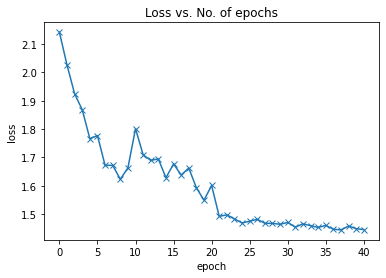

In [ ]:
plot_losses(history)

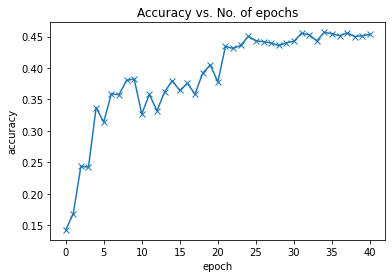

In [ ]:
plot_accuracies(history)

In [ ]:
evaluate(model, test_dataloader)

{'val_loss': 1.479780673980713, 'val_acc': 0.4390231668949127}

In [ ]:
torch.save(model.state_dict(), 'emotion_classification-feedforward.pth')